# This notebook gets essential data about the 2022 FIFA World Cup and implements a naive model to simulate the tournament to predict the winner, 2nd place, 3rd place, and 4th place.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

%matplotlib inline

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

### Make the plots look nicer

In [3]:
# Some code to make the plots look nicer
plt.rcParams['figure.dpi'] = 150
sns.set_theme(font='Georgia', style="whitegrid", palette="pastel")
sns.set_context(
    "notebook", 
    rc={
        "font.size":      16,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "axes.labelpad":  15,
        "axes.titlepad":  15,
        # grid
        "grid.linewidth": 0.5,
        "grid.linestyle": ":",
    })

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

color_list = [CB91_Blue, CB91_Amber, CB91_Pink, CB91_Green, CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

# Some Exploratory Data Analysis

The `df_matches` dataframe contains the match data and has the following columns:
['Year', 'Datetime', 'Stage', 'Stadium', 'City', 'Home Team Name', 'Home Team Goals', 'Away Team Goals', 'Away Team Name', 'Win conditions', 'Attendance', 'Half-time Home Goals', 'Half-time Away Goals', 'Referee', 'Assistant 1', 'Assistant 2', 'RoundID', 'MatchID', 'Home Team Initials', 'Away Team Initials']
* `Year`: The year of the match
* `Datetime`: The Date on which the match was played along with a 24 hour format time
* `Stage`: The stage at which the match was played
* `Stadium`: The stadium in which the match was held
* `City`: The city name, where the match was held
* `Home Team Name`: Home team country name
* `Home Team Goals`: Total goals scored by the home team by the end of the match
* `Away Team Goals`: Total goals scored by the away team by the end of the match
* `Away Team Name`: Away team country name
* `Win conditions`: Special win condition (if any)

In [4]:
# Exploring the data
df_matches = pd.read_csv('data/Matches/WorldCupMatches.csv')
df_players = pd.read_csv('data/Matches/WorldCupPlayers.csv')
df_cups = pd.read_csv('data/Matches/WorldCups.csv')
df_groups = pd.read_csv('data/group_stage_22.csv')

# Display the first 5 rows of all the dataframes
print('df_matches has {} rows and {} columns'.format(df_matches.shape[0], df_matches.shape[1]))
display(df_matches.head())
print('\ndf_players has {} rows and {} columns'.format(df_players.shape[0], df_players.shape[1]))
display(df_players.head())
print('\ndf_cups has {} rows and {} columns'.format(df_cups.shape[0], df_cups.shape[1]))
display(df_cups.head())
print('\ndf_groups has {} rows and {} columns'.format(df_groups.shape[0], df_groups.shape[1]))
display(df_groups.head())

df_matches has 4572 rows and 20 columns


,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials
0,1930.0,13 Jul 1930 - 15:00,Group 1,Pocitos,Montevideo,France,4.0,1.0,Mexico,,4444.0,3.0,0.0,LOMBARDI Domingo (URU),CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX
1,1930.0,13 Jul 1930 - 15:00,Group 4,Parque Central,Montevideo,USA,3.0,0.0,Belgium,,18346.0,2.0,0.0,MACIAS Jose (ARG),MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,USA,BEL
2,1930.0,14 Jul 1930 - 12:45,Group 2,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,24059.0,2.0,0.0,TEJADA Anibal (URU),VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA
3,1930.0,14 Jul 1930 - 14:50,Group 3,Pocitos,Montevideo,Romania,3.0,1.0,Peru,,2549.0,1.0,0.0,WARNKEN Alberto (CHI),LANGENUS Jean (BEL),MATEUCCI Francisco (URU),201.0,1098.0,ROU,PER
4,1930.0,15 Jul 1930 - 16:00,Group 1,Parque Central,Montevideo,Argentina,1.0,0.0,France,,23409.0,0.0,0.0,REGO Gilberto (BRA),SAUCEDO Ulises (BOL),RADULESCU Constantin (ROU),201.0,1085.0,ARG,FRA



df_players has 37784 rows and 9 columns


,RoundID,MatchID,Team Initials,Coach Name,Line-up,Shirt Number,Player Name,Position,Event
0,201,1096,FRA,CAUDRON Raoul (FRA),S,0,Alex THEPOT,GK,NaN
1,201,1096,MEX,LUQUE Juan (MEX),S,0,Oscar BONFIGLIO,GK,NaN
2,201,1096,FRA,CAUDRON Raoul (FRA),S,0,Marcel LANGILLER,NaN,G40'
3,201,1096,MEX,LUQUE Juan (MEX),S,0,Juan CARRENO,NaN,G70'
4,201,1096,FRA,CAUDRON Raoul (FRA),S,0,Ernest LIBERATI,NaN,NaN



df_cups has 20 rows and 10 columns


,Year,Country,Winner,Runners-Up,Third,Fourth,GoalsScored,QualifiedTeams,MatchesPlayed,Attendance
0,1930,Uruguay,Uruguay,Argentina,USA,Yugoslavia,70,13,18,590.549
1,1934,Italy,Italy,Czechoslovakia,Germany,Austria,70,16,17,363.000
2,1938,France,Italy,Hungary,Brazil,Sweden,84,15,18,375.700
3,1950,Brazil,Uruguay,Brazil,Sweden,Spain,88,13,22,1.045.246
4,1954,Switzerland,Germany FR,Hungary,Austria,Uruguay,140,16,26,768.607



df_groups has 48 rows and 3 columns


,Home Team,Away Team,Group
0,Qatar,Ecuador,a
1,Senegal,Netherlands,a
2,England,IR Iran,b
3,USA,Wales,b
4,France,Australia,d


In [5]:
# Save column names for later use
matches_cols = df_matches.columns
players_cols = df_players.columns
cups_cols = df_cups.columns

# print column names
print('df_matches columns: {}'.format(matches_cols))
print('df_players columns: {}'.format(players_cols))
print('df_cups columns: {}'.format(cups_cols))

df_matches columns: Index(['Year', 'Datetime', 'Stage', 'Stadium', 'City', 'Home Team Name', 'Home Team Goals', 'Away Team Goals', 'Away Team Name', 'Win conditions', 'Attendance', 'Half-time Home Goals', 'Half-time Away Goals', 'Referee', 'Assistant 1', 'Assistant 2', 'RoundID', 'MatchID', 'Home Team Initials', 'Away Team Initials'], dtype='object')
df_players columns: Index(['RoundID', 'MatchID', 'Team Initials', 'Coach Name', 'Line-up', 'Shirt Number', 'Player Name', 'Position', 'Event'], dtype='object')
df_cups columns: Index(['Year', 'Country', 'Winner', 'Runners-Up', 'Third', 'Fourth', 'GoalsScored', 'QualifiedTeams', 'MatchesPlayed', 'Attendance'], dtype='object')


In [6]:
# change Germany FR and German DR to Germany in all dataframes and all occurrences
for df in [df_matches, df_players, df_cups]:
    df.replace(['Germany FR', 'German DR'], 'Germany', inplace=True)
# print countries unique values
countries_hist = df_matches['Home Team Name'].unique()
# check if there are Germany FR or German DR in the dataframes
print('Germany FR in df_matches: {}'.format('Germany FR' in countries_hist))

Germany FR in df_matches: False


In [7]:
round_of_16 = df_groups.iloc[48:56, :] 
quarter_finals = df_groups.iloc[56:60, :]
semi_finals = df_groups.iloc[60:62, :]
final = df_groups.iloc[62:63, :]
third_place = df_groups.iloc[63:64, :]

# The Naive Model

Our naive model predicts the winner of the world cup in addition to the 2nd, 3rd and 4th place teams. The model simulates the tournament by selecting the winner of each match based on the following rules: For each team, we calculate the win probability as the number of wins divided by the number of matches in which the team participated in the list of all matches in the world cup history. The team with the higher win probability wins the match. If the win probabilities are equal, then the winner is selected randomly. 

In the group stage, we have 8 groups (A, B, ..., H) of 4 teams each. In each group, 6 matches take place, and the two teams with the highest number of points are selected to advance to the next round. The points are calculated as follows: 3 points for a win, 1 point for a draw and 0 points for a loss. Hence, 16 teams advance to the next round, with 2 from each group. If there is a draw between points, then the tie is ideally broken by the following rules: 1) Goal difference, 2) Goals scored, 3) Fair play points, 4) Fair play goal difference, 5) Fair play goals scored, 6) Drawing of lots. However, our naive model does not take into account any of these rules, and simply breaks ties randomly.

In the next round, the 16 teams are divided into 8 matches with a predetermined pairing (the winner from group A plays the winner from group B, and so on). The winner of each match advances to the next round (there are no ties allowed, and hence our naive model breaks the ties randomly). The game goes on till the final match, where we find winner of the world cup. The two runner ups in the semi finals then play the third place match to decide the third place and fourth place teams.

This model is non-parametric, and hence does not require any training. However, it is a good starting point that uses the historical data to predict the winner of the world cup. The model we intend to build, however, will be parametric. The winner of the world cup is Brazil! Second, third, and fourth place is Portugal, Argentina, and Denmark, respectively. Below you can see the visualized tournament results.


In [8]:
# For every country in df_groups, get the ration of matches won to total matches played in df_matches
def get_win_ratio(country, df_matches):
    # get all matches where the country is the home team
    home_matches = df_matches[df_matches['Home Team Name'] == country]
    # get all matches where the country is the away team
    away_matches = df_matches[df_matches['Away Team Name'] == country]
    # get the total number of matches played by the country
    total_matches = len(home_matches) + len(away_matches)
    # get the total number of matches won by the country
    total_wins = len(home_matches[home_matches['Home Team Goals'] > home_matches['Away Team Goals']]) + len(away_matches[away_matches['Away Team Goals'] > away_matches['Home Team Goals']])
    # return the ratio of wins to total matches played

    return total_wins / total_matches if total_matches > 0 else 0

# Run the tournament's matches starting with the group stage
# For each group, the winner of each match gets 3 points, the loser gets 0 points
# A draw gets 1 point for each team
# The top 2 teams in each group advance to the round of 16
winners_group_stage = {}
for group in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']:
    
    # df_groups has columns Home Team, Away Team, Group
    group_df = df_groups[df_groups['Group'] == group]
    home_teams_df = group_df['Home Team']
    away_teams_df = group_df['Away Team']
    
    # get a set of all the teams in the group
    group_teams_names = set(home_teams_df.values) | set(away_teams_df.values)
    group_win_ratios = {team : get_win_ratio(team, df_matches) for team in group_teams_names}
    home_team_win_ratio = home_teams_df.map(group_win_ratios)
    away_team_win_ratio = away_teams_df.map(group_win_ratios)
    
    # dataframes for winner teams and draw teams
    winners = pd.concat([home_teams_df[home_team_win_ratio > away_team_win_ratio], away_teams_df[home_team_win_ratio < away_team_win_ratio]])
    draws = pd.concat([home_teams_df[home_team_win_ratio == away_team_win_ratio], away_teams_df[home_team_win_ratio == away_team_win_ratio]])
    
    # calculate the points for each team
    points = {team : 0 for team in group_teams_names}
    # for winner teams, add 3 points
    for winner in winners: points[winner] += 3
    # for draw teams, add 1 point
    for draw in draws: points[draw] += 1

    # print(f"Home teams for group {group}: {home_teams_df.values}")
    # print(f"Away teams for group {group}: {away_teams_df.values}")
    # print(f"home_team_win_ratio         : {home_team_win_ratio.values}")
    # print(f"away_team_win_ratio         : {away_team_win_ratio.values}")
    # print(f"Winners for group    {group}: {winners.values}")
    # print("Points for group     {}: {}".format(group, points))
    # print()
    # get the top 2 teams in the group
    group_winners = sorted(points, key=points.get, reverse=True)[:2]
    winners_group_stage[group] = group_winners

In [9]:
winners_group_stage

{'a': ['Netherlands', 'Senegal'],
 'b': ['England', 'USA'],
 'c': ['Argentina', 'Poland'],
 'd': ['Denmark', 'France'],
 'e': ['Germany', 'Spain'],
 'f': ['Croatia', 'Belgium'],
 'g': ['Brazil', 'Serbia'],
 'h': ['Portugal', 'Uruguay']}

In [10]:
# now we have the winners of the group stage
# for round of 16, we have 8 matches
# the top performer from each group plays the second best performer from the other group
# There has to be a winner, which advances to the quarter finals
winners_round_of_16 = {}
for group1, group2 in [('a', 'b'), ('c', 'd'), ('e', 'f'), ('g', 'h')]:
    # get the top 2 teams from each group
    group1_teams = winners_group_stage[group1]
    group2_teams = winners_group_stage[group2]
    # get the win ratios for each team
    group1_win_ratios = {team : get_win_ratio(team, df_matches) for team in group1_teams}
    group2_win_ratios = {team : get_win_ratio(team, df_matches) for team in group2_teams}
    # the top player from group1 plays the second best player from group2
    # the top player from group2 plays the second best player from group1
    winner_match_1 = group1_teams[0] if group1_win_ratios[group1_teams[0]] > group2_win_ratios[group2_teams[1]] else group2_teams[1]
    winner_match_2 = group2_teams[0] if group2_win_ratios[group2_teams[0]] > group1_win_ratios[group1_teams[1]] else group1_teams[1]
    winners_round_of_16[group1 + "1" + group2 + "2"] = winner_match_1
    winners_round_of_16[group1 + "2" + group2 + "1"] = winner_match_2

In [11]:
winners_round_of_16

{'a1b2': 'Netherlands',
 'a2b1': 'England',
 'c1d2': 'Argentina',
 'c2d1': 'Denmark',
 'e1f2': 'Germany',
 'e2f1': 'Spain',
 'g1h2': 'Brazil',
 'g2h1': 'Portugal'}

In [12]:
quarter_finals_winners = {}
# quarter finals
# a1b2 vs. c1d2
# a2b1 vs. c2d1
# e1f2 vs. g1h2
# e2f1 vs. g2h1
for team1_str, team2_str in [('a1b2', 'c1d2'), ('a2b1', 'c2d1'), ('e1f2', 'g1h2'), ('e2f1', 'g2h1')]:
    # get the teams for the match
    team1 = winners_round_of_16[team1_str]
    team2 = winners_round_of_16[team2_str]
    # get the win ratios for each team
    team1_win_ratio = get_win_ratio(team1, df_matches)
    team2_win_ratio = get_win_ratio(team2, df_matches)
    # the team with the higher win ratio wins
    winner = team1 if team1_win_ratio > team2_win_ratio else team2
    quarter_finals_winners[team1_str + team2_str] = winner

quarter_finals_winners

{'a1b2c1d2': 'Argentina',
 'a2b1c2d1': 'Denmark',
 'e1f2g1h2': 'Brazil',
 'e2f1g2h1': 'Portugal'}

In [13]:
finalists = {}
third_place_teams = {}
# semi finals
# a1b2c1d2 vs. e1f2g1h2
# a2b1c2d1 vs. e2f1g2h1
for team1_str, team2_str in [('a1b2c1d2', 'e1f2g1h2'), ('a2b1c2d1', 'e2f1g2h1')]:
    # get the teams for the match
    team1 = quarter_finals_winners[team1_str]
    team2 = quarter_finals_winners[team2_str]
    # get the win ratios for each team
    team1_win_ratio = get_win_ratio(team1, df_matches)
    team2_win_ratio = get_win_ratio(team2, df_matches)
    # the team with the higher win ratio wins
    winner = team1 if team1_win_ratio > team2_win_ratio else team2
    print(f"{team1} vs. {team2} : {winner} wins")
    finalists[team1_str + team2_str] = winner
    # the team with the lower win ratio is the third place team
    third_place_teams[team1_str + team2_str] = team2 if team1_win_ratio > team2_win_ratio else team1
    

print(f"Finalists: {finalists}")
print(f"Third place teams: {third_place_teams}")

Argentina vs. Brazil : Brazil wins
Denmark vs. Portugal : Portugal wins
Finalists: {'a1b2c1d2e1f2g1h2': 'Brazil', 'a2b1c2d1e2f1g2h1': 'Portugal'}
Third place teams: {'a1b2c1d2e1f2g1h2': 'Argentina', 'a2b1c2d1e2f1g2h1': 'Denmark'}


In [14]:
# final
# a1b2c1d2e1f2g1h2 vs. a2b1c2d1e2f1g2h1
team1 = finalists['a1b2c1d2e1f2g1h2']
team2 = finalists['a2b1c2d1e2f1g2h1']
# get the win ratios for each team
team1_win_ratio = get_win_ratio(team1, df_matches)
team2_win_ratio = get_win_ratio(team2, df_matches)
# the team with the higher win ratio wins
winner_of_world_cup = team1 if team1_win_ratio > team2_win_ratio else team2
# the team with the lower win ratio is the second place team
second_place_team = team2 if team1_win_ratio > team2_win_ratio else team1

team1 = third_place_teams['a1b2c1d2e1f2g1h2']
team2 = third_place_teams['a2b1c2d1e2f1g2h1']
# get the win ratios for each team
team1_win_ratio = get_win_ratio(team1, df_matches)
team2_win_ratio = get_win_ratio(team2, df_matches)
# the team with the higher win ratio wins
third_place_team = team1 if team1_win_ratio > team2_win_ratio else team2
fourth_place_team = team2 if team1_win_ratio > team2_win_ratio else team1

print(f"The winner of the world cup is {winner_of_world_cup}!")
print(f"2nd place:                     {second_place_team}")
print(f"3rd place:                     {third_place_team}")
print(f"4th place:                     {fourth_place_team}")



The winner of the world cup is Brazil!
2nd place:                     Portugal
3rd place:                     Argentina
4th place:                     Denmark


In [15]:
!pip install networkx

In [16]:
winners_group_stage

{'a': ['Netherlands', 'Senegal'],
 'b': ['England', 'USA'],
 'c': ['Argentina', 'Poland'],
 'd': ['Denmark', 'France'],
 'e': ['Germany', 'Spain'],
 'f': ['Croatia', 'Belgium'],
 'g': ['Brazil', 'Serbia'],
 'h': ['Portugal', 'Uruguay']}

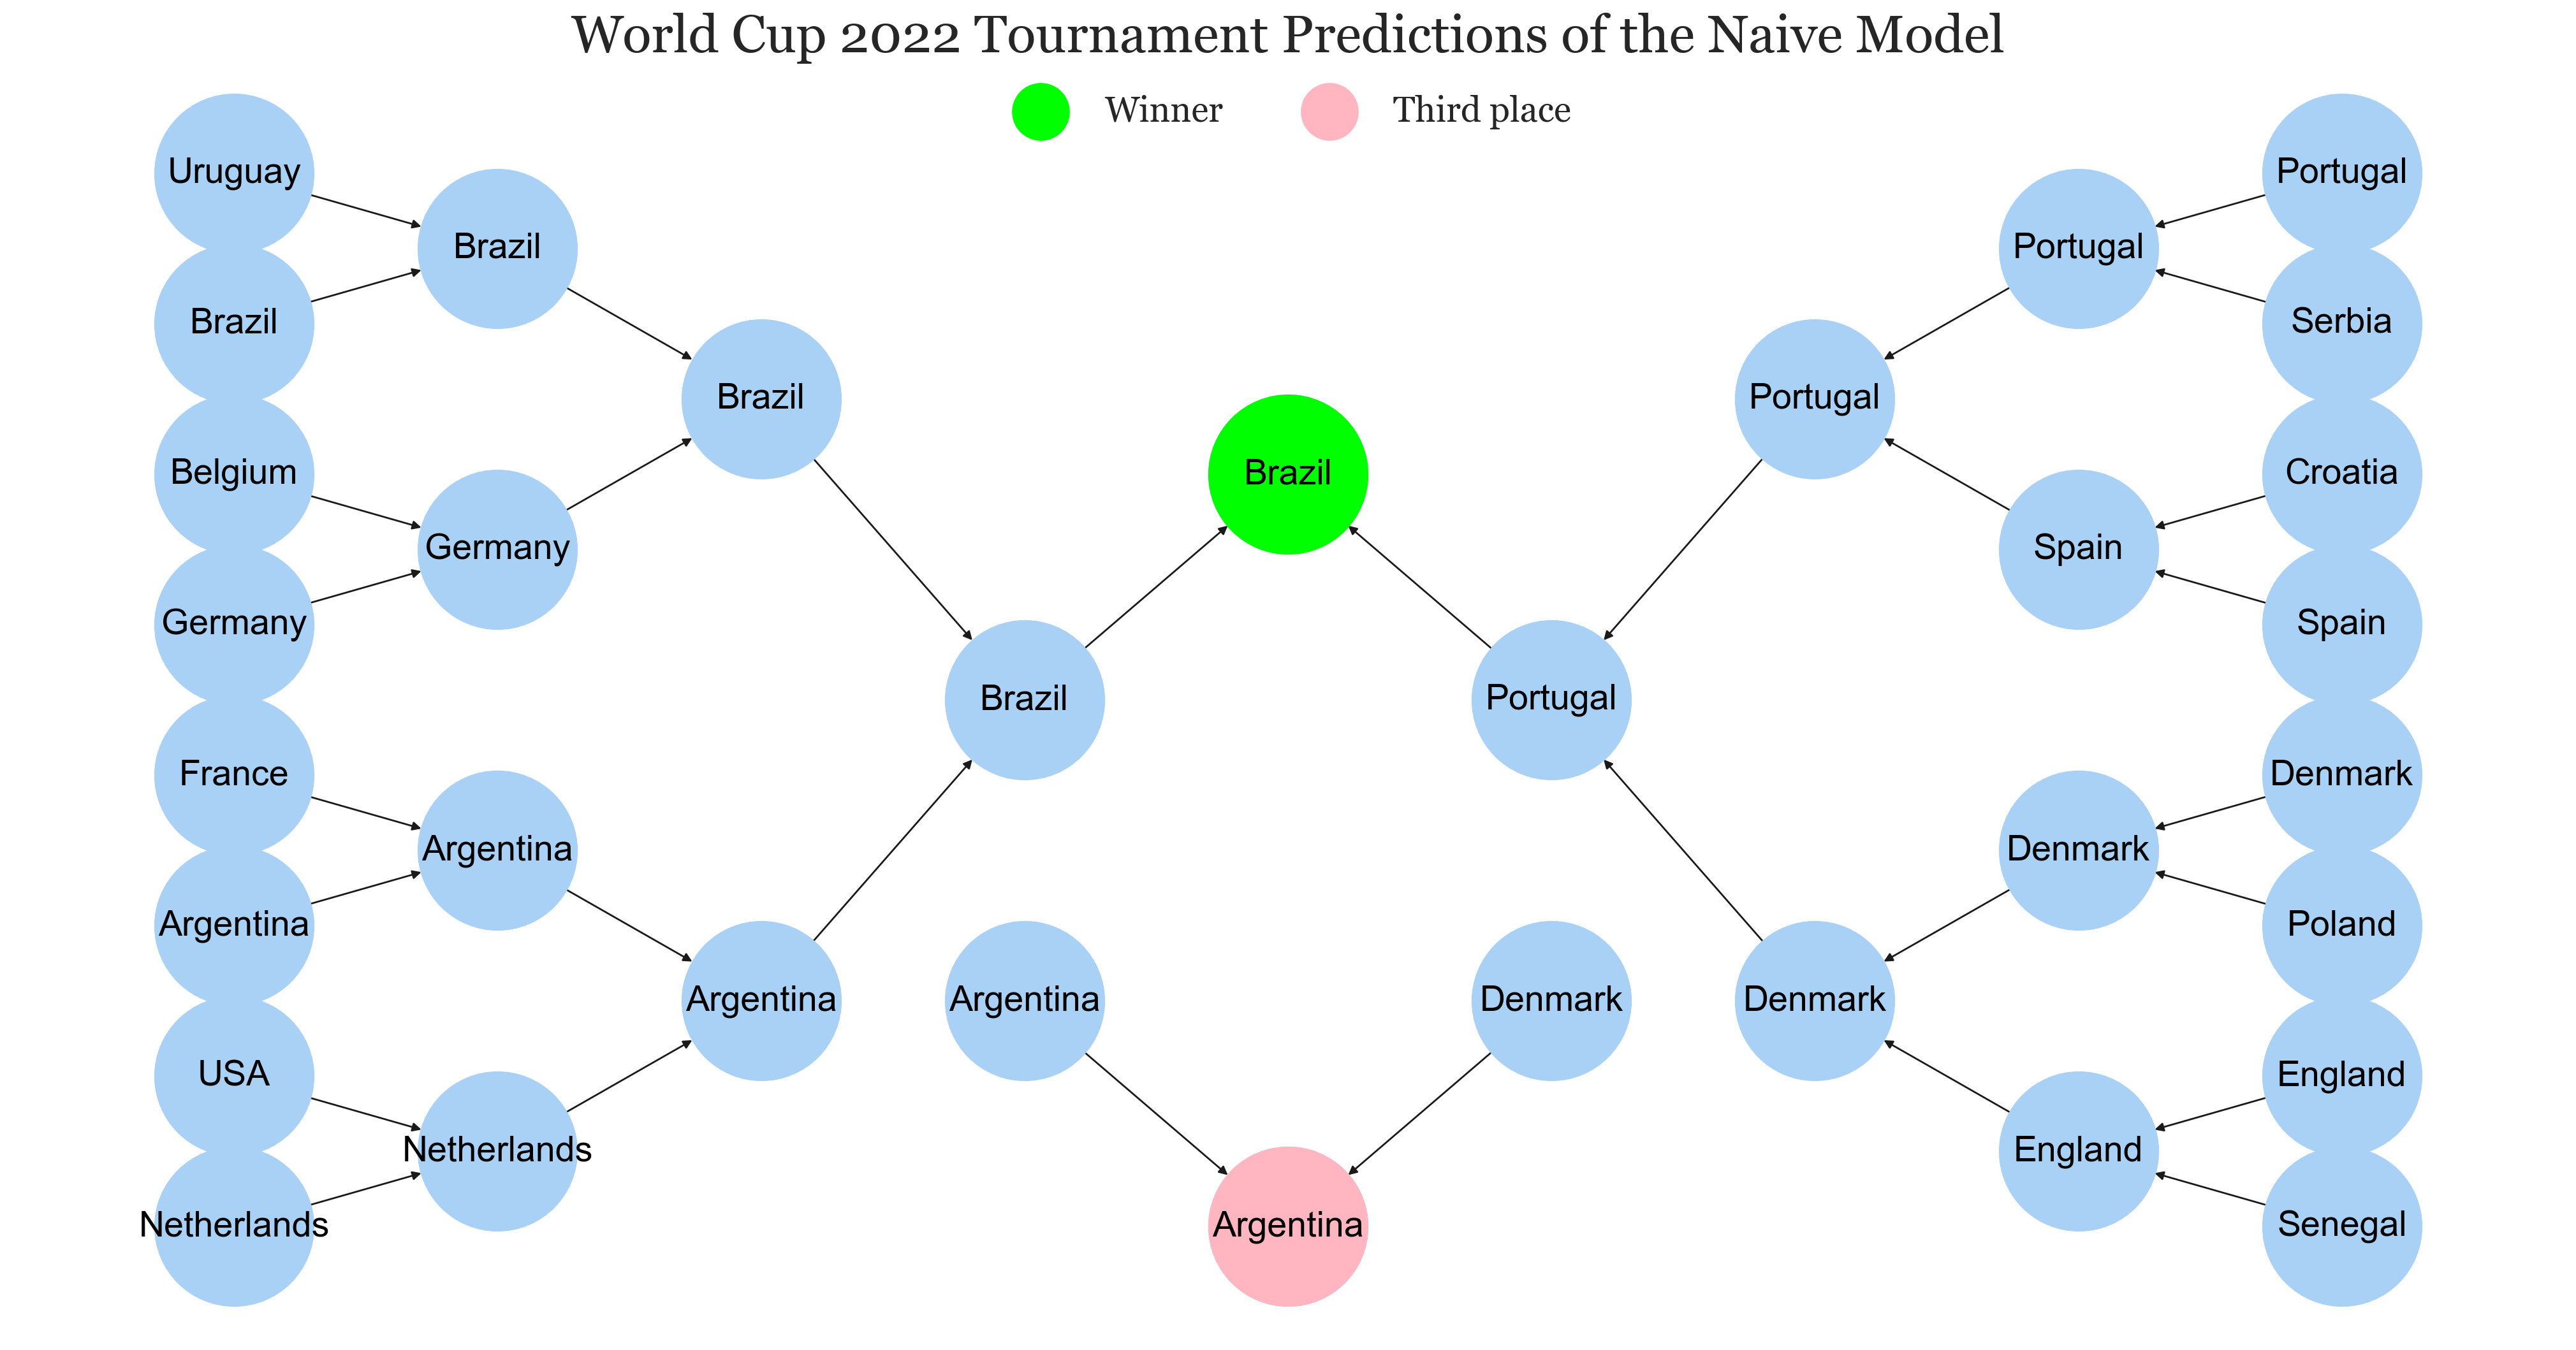

In [17]:
# Visualize the results as a node graph
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# add the nodes a1, b2, c1, d2, e1, f2, g1, h2 to the most left layer of the graph
# add the nodes a2, b1, c2, d1, e2, f1, g2, h1 to the most right layer of the graph
# add the nodes a1b2, c1d2, e1f2, g1h2 to the second left layer of the graph
# add the nodes a2b1, c2d1, e2f1, g2h1 to the second right layer of the graph
# add the nodes a1b2c1d2, e1f2g1h2 to the third left layer of the graph
# add the nodes a2b1c2d1, e2f1g2h1 to the third right layer of the graph
# add the nodes a1b2c1d2e1f2g1h2 to the fourth left layer of the graph
# add the nodes a2b1c2d1e2f1g2h1 to the fourth right layer of the graph
teams = {}
layer_0_team_names = ['a1', 'b2', 'c1', 'd2', 'e1', 'f2', 'g1', 'h2']
layer_8_team_names = ['a2', 'b1', 'c2', 'd1', 'e2', 'f1', 'g2', 'h1']
layer_0_team_names = [winners_group_stage[team_name[0]][int(team_name[1])-1] for team_name in layer_0_team_names]
layer_8_team_names = [winners_group_stage[team_name[0]][int(team_name[1])-1] for team_name in layer_8_team_names]
layer_1_team_names = [winners_round_of_16[team_name] for team_name in ['a1b2', 'c1d2', 'e1f2', 'g1h2']]
layer_2_team_names = [quarter_finals_winners[team_name] for team_name in ['a1b2c1d2', 'e1f2g1h2']]
layer_6_team_names = [quarter_finals_winners[team_name] for team_name in ['a2b1c2d1', 'e2f1g2h1']]
layer_7_team_names = [winners_round_of_16[team_name] for team_name in ['a2b1', 'c2d1', 'e2f1', 'g2h1']]
[G.add_node(team, layer=0, order=i) for team, i in zip(['a1', 'b2', 'c1', 'd2', 'e1', 'f2', 'g1', 'h2'], range(8))]
[G.add_node(team, layer=8, order=i) for team, i in zip(['a2', 'b1', 'c2', 'd1', 'e2', 'f1', 'g2', 'h1'], range(8))]
[G.add_node(team, layer=1, order=.5+2*i) for team, i in zip(['a1b2', 'c1d2', 'e1f2', 'g1h2'], range(4))]
[G.add_node(team, layer=7, order=.5+2*i) for team, i in zip(['a2b1', 'c2d1', 'e2f1', 'g2h1'], range(4))]
[G.add_node(team, layer=2, order=1.5+4*i) for team, i in zip(['a1b2c1d2', 'e1f2g1h2'], range(2))]
[G.add_node(team, layer=6, order=1.5+4*i) for team, i in zip(['a2b1c2d1', 'e2f1g2h1'], range(2))]
G.add_node('a1b2c1d2e1f2g1h2', layer=3, order=3.5)
G.add_node('a2b1c2d1e2f1g2h1', layer=5, order=3.5)
G.add_node('a1b2c1d2e1f2g1h2a2b1c2d1e2f1g2h1', layer=4, order=5)
# add three nodes for the third place teams
G.add_node(third_place_team, layer=3, order=1.5)
G.add_node(fourth_place_team, layer=5, order=1.5)
G.add_node("3rd place:" + third_place_team, layer=4, order=0)

# add to teams dict
teams.update({string: team for string, team in zip(['a1', 'b2', 'c1', 'd2', 'e1', 'f2', 'g1', 'h2'], layer_0_team_names)})
teams.update({string: team for string, team in zip(['a2', 'b1', 'c2', 'd1', 'e2', 'f1', 'g2', 'h1'], layer_8_team_names)})
teams.update({string: team for string, team in zip(['a1b2', 'c1d2', 'e1f2', 'g1h2'], layer_1_team_names)})
teams.update({string: team for string, team in zip(['a2b1', 'c2d1', 'e2f1', 'g2h1'], layer_7_team_names)})
teams.update({string: team for string, team in zip(['a1b2c1d2', 'e1f2g1h2'], layer_2_team_names)})
teams.update({string: team for string, team in zip(['a2b1c2d1', 'e2f1g2h1'], layer_6_team_names)})
teams.update({'a1b2c1d2e1f2g1h2': finalists['a1b2c1d2e1f2g1h2']})
teams.update({'a2b1c2d1e2f1g2h1': finalists['a2b1c2d1e2f1g2h1']})
teams.update({'a1b2c1d2e1f2g1h2a2b1c2d1e2f1g2h1' : winner_of_world_cup})
teams.update({'3rd place:' + third_place_team: third_place_team})
teams.update({third_place_team: third_place_team})
teams.update({fourth_place_team: fourth_place_team})

# add the edges
team1_team2_winner_list_of_tuples = \
    list(zip(['a1', 'c1', 'e1', 'g1'], ['b2', 'd2', 'f2', 'h2'], ['a1b2', 'c1d2', 'e1f2', 'g1h2'])) + \
    list(zip(['a2', 'c2', 'e2', 'g2'], ['b1', 'd1', 'f1', 'h1'], ['a2b1', 'c2d1', 'e2f1', 'g2h1'])) + \
    list(zip(['a1b2', 'e1f2'], ['c1d2', 'g1h2'], ['a1b2c1d2', 'e1f2g1h2'])) + \
    list(zip(['a2b1', 'e2f1'], ['c2d1', 'g2h1'], ['a2b1c2d1', 'e2f1g2h1'])) + \
    list(zip(['a1b2c1d2'], ['e1f2g1h2'], ['a1b2c1d2e1f2g1h2'])) + \
    list(zip(['a2b1c2d1'], ['e2f1g2h1'], ['a2b1c2d1e2f1g2h1'])) + \
    [('a1b2c1d2e1f2g1h2', 'a2b1c2d1e2f1g2h1', 'a1b2c1d2e1f2g1h2a2b1c2d1e2f1g2h1')] + \
    [(third_place_team, fourth_place_team, "3rd place:" + third_place_team)]

for team1, team2, winner in team1_team2_winner_list_of_tuples:
    G.add_edge(team1, winner)
    G.add_edge(team2, winner)

# draw the layers
pos = {}
for node in G.nodes():
    pos[node] = (G.nodes[node]['layer'], G.nodes[node]['order'])
# draw the graph with high dpi  
plt.figure(figsize=(20, 10), dpi=200)
# baby blue nodes
nx.draw(G, pos=pos, labels=teams, node_size=8000, font_size=20, font_color='black', node_color='#A9D0F5', with_labels=True)
# draw the winner in green and write winner above it
nx.draw_networkx_nodes(G, pos=pos, nodelist=['a1b2c1d2e1f2g1h2a2b1c2d1e2f1g2h1'], node_size=8000, node_color='#00FF00')
# draw the third place team in light red
nx.draw_networkx_nodes(G, pos=pos, nodelist=['3rd place:' + third_place_team], node_size=8000, node_color='#FFB6C1')
# add legends for green and light red
plt.scatter([], [], c='#00FF00', s=1000, label='Winner')
plt.scatter([], [], c='#FFB6C1', s=1000, label='Third place')
plt.legend(loc='upper center', ncol=2, fontsize=20, frameon=False)
plt.title('World Cup 2022 Tournament Predictions of the Naive Model', fontsize=30)
# save the image
plt.savefig('world_cup_2022_winner.png', dpi=200)
plt.show()
